In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = '/content/drive/MyDrive/New_datasets/New_datasets'
folders = os.listdir(dir)
file_path = []
labels = []
sub_folders =[]
for folder in folders:
    sub_folder = os.path.join(dir, folder)
    sub_list = os.listdir(sub_folder)
    for file in sub_list:
        f_path = os.path.join(sub_folder, file)
        file_path.append(f_path)
        labels.append(folder)

df = pd.DataFrame({'file_path': file_path, "labels": labels})
df.head()

,file_path,labels
0,/kaggle/input/barin-tumor-dataset/New_datasets...,no_tumor
1,/kaggle/input/barin-tumor-dataset/New_datasets...,no_tumor
2,/kaggle/input/barin-tumor-dataset/New_datasets...,no_tumor
3,/kaggle/input/barin-tumor-dataset/New_datasets...,no_tumor
4,/kaggle/input/barin-tumor-dataset/New_datasets...,no_tumor


## Exploratory Data Analysis

labels
meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            396
Name: count, dtype: int64


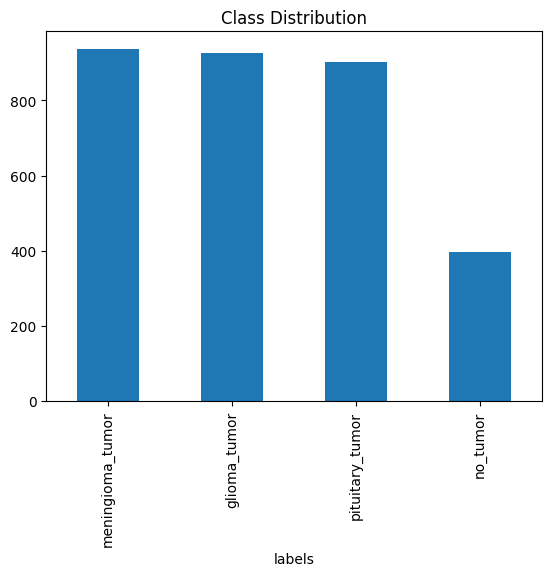

In [ ]:
df['labels'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
print(df['labels'].value_counts())

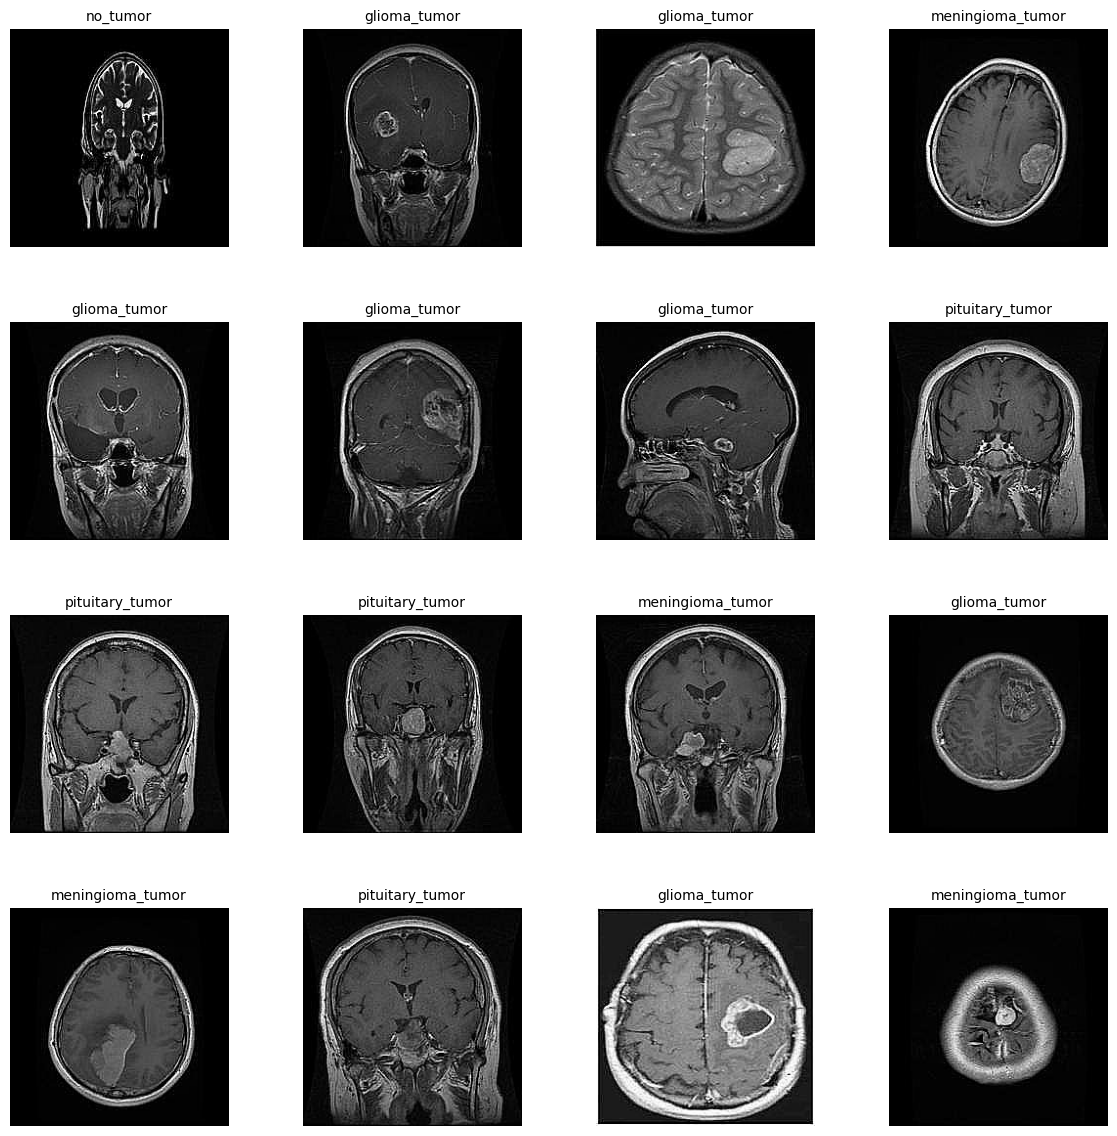

In [ ]:
# Select 16 random images from the dataset
sampled_images = df.sample(16).reset_index()

# Set up the layout for displaying images in a grid
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
fig.tight_layout(pad=2.0)  # Adjust the spacing between grid cells

# Loop through each grid cell and plot the corresponding image and its label
for index, axis in enumerate(axes.flat):
    image_path = sampled_images.loc[index, 'file_path']  # Get the image file path
    image_label = sampled_images.loc[index, 'labels']    # Get the image label
    image = mpimg.imread(image_path)  # Load the image from the file path
    axis.imshow(image)  # Display the image in the grid cell
    axis.set_title(image_label, fontsize=10)  # Set the title with the label
    axis.axis('off')  # Hide the axes for a cleaner visualization

plt.show()

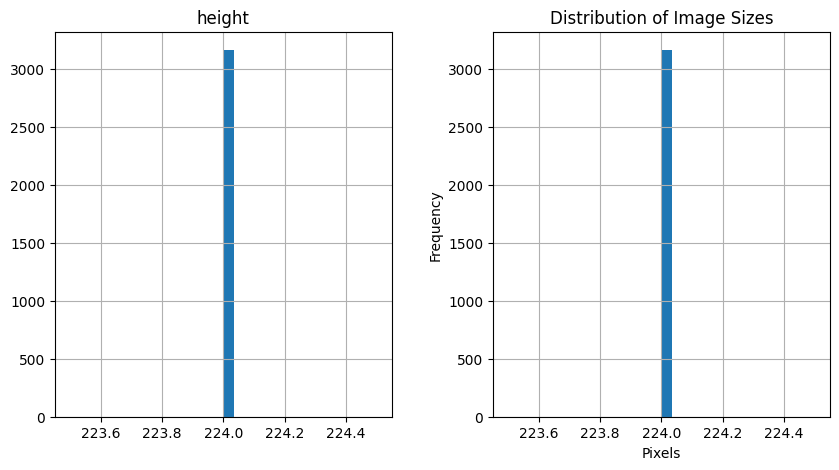

In [ ]:
image_sizes = []
for path in df['file_path']:
    img = cv2.imread(path)
    image_sizes.append(img.shape[:2])

image_sizes_df = pd.DataFrame(image_sizes, columns=['height', 'width'])
image_sizes_df.hist(bins=30, figsize=(10, 5))
plt.title('Distribution of Image Sizes')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.show()

## Data Preprocessing

In [ ]:
# Split the data into training (70%), validation (15%), and testing (15%)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['labels'])
test_df_rf = test_df.copy()
val_df_rf = val_df.copy()

In [ ]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['labels']), y=train_df['labels'])
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and testing data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation
)

Found 2212 validated image filenames belonging to 4 classes.
Found 474 validated image filenames belonging to 4 classes.
Found 474 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load ResNet-50 for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Extract features
train_features = feature_extractor.predict(train_generator)
val_features = feature_extractor.predict(val_generator)
test_features = feature_extractor.predict(test_generator)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


## Modeling

## CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile CNN
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN
history_cnn = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10,
    class_weight=class_weights_dict
)

# Evaluate CNN
test_loss, test_accuracy = cnn_model.evaluate(test_generator, steps=len(test_generator))
print(f"CNN Test Accuracy: {test_accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 354ms/step - accuracy: 0.2616 - loss: 1.5249 - val_accuracy: 0.4177 - val_loss: 1.3334
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 327ms/step - accuracy: 0.4342 - loss: 1.2336 - val_accuracy: 0.4262 - val_loss: 1.3122
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 322ms/step - accuracy: 0.4685 - loss: 1.1698 - val_accuracy: 0.4768 - val_loss: 1.2446
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 323ms/step - accuracy: 0.5182 - loss: 1.0858 - val_accuracy: 0.3734 - val_loss: 1.5434
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 324ms/step - accuracy: 0.5354 - loss: 1.0818 - val_accuracy: 0.4789 - val_loss: 1.3435
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 128us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4551 - loss: 1.4262
CNN Test Accuracy: 0.46


## ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load ResNet-50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes

# Create the model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile ResNet-50
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train ResNet-50
history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10,
    class_weight=class_weights_dict
)

# Evaluate ResNet-50
test_loss, test_accuracy = resnet_model.evaluate(test_generator, steps=len(test_generator))
print(f"ResNet-50 Test Accuracy: {test_accuracy:.2f}")
resnet_test_preds = resnet_model.predict(test_generator, steps=len(test_generator))
resnet_test_preds = np.argmax(resnet_test_preds, axis=1)


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 415ms/step - accuracy: 0.3162 - loss: 1.4473 - val_accuracy: 0.3755 - val_loss: 1.3284
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 333ms/step - accuracy: 0.4165 - loss: 1.2704 - val_accuracy: 0.2236 - val_loss: 1.7187
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 339ms/step - accuracy: 0.4090 - loss: 1.2684 - val_accuracy: 0.3987 - val_loss: 1.3014
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 340ms/step - accuracy: 0.4324 - loss: 1.2073 - val_accuracy: 0.3776 - val_loss: 1.3026
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 328ms/step - accuracy: 0.3808 - loss: 1.3380 - val_accuracy: 0.398

In [ ]:
label_to_category = {
    'glioma_tumor': 0,
    'meningioma_tumor': 1,
    'no_tumor': 2,
    'pituitary_tumor': 3
}
test_df['labels'] = test_df['labels'].map(label_to_category)
val_df['labels'] = val_df['labels'].map(label_to_category)
print("ResNet-50 Test Results:")
print("ResNet-50 Validation Accuracy:", classification_report(test_df['labels'], resnet_test_preds))

ResNet-50 Test Results:
ResNet-50 Validation Accuracy:               precision    recall  f1-score   support

           0       0.75      0.09      0.15       139
           1       0.54      0.32      0.40       141
           2       0.20      0.80      0.32        59
           3       0.45      0.48      0.47       135

    accuracy                           0.36       474
   macro avg       0.49      0.42      0.34       474
weighted avg       0.54      0.36      0.34       474



## RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_df['labels'])

# Evaluate Random Forest
val_preds = rf_model.predict(val_features)
print("Random Forest Validation Accuracy:", accuracy_score(val_df_rf['labels'], val_preds))
print(classification_report(val_df_rf['labels'], val_preds))

Random Forest Validation Accuracy: 0.30168776371308015
                  precision    recall  f1-score   support

    glioma_tumor       0.31      0.46      0.37       139
meningioma_tumor       0.30      0.35      0.33       140
        no_tumor       0.00      0.00      0.00        60
 pituitary_tumor       0.29      0.22      0.25       135

        accuracy                           0.30       474
       macro avg       0.23      0.26      0.24       474
    weighted avg       0.26      0.30      0.28       474



## Evaluation

## Comparison of CNN,ReseNet50, and RandomForestClassifier

In [ ]:
from sklearn.metrics import classification_report


# Random Forest
rf_test_preds = rf_model.predict(test_features)
print("Random Forest Test Results:")
print(classification_report(test_df_rf['labels'], rf_test_preds))

# CNN
cnn_test_preds = cnn_model.predict(test_generator, steps=len(test_generator))
cnn_test_preds = np.argmax(cnn_test_preds, axis=1)
print("CNN Test Results:")
print(classification_report(test_df['labels'], cnn_test_preds))

# ResNet-50
resnet_test_preds = resnet_model.predict(test_generator, steps=len(test_generator))
resnet_test_preds = np.argmax(resnet_test_preds, axis=1)
print("ResNet-50 Test Results:")
print(classification_report(test_df['labels'], resnet_test_preds))

Random Forest Test Results:
                  precision    recall  f1-score   support

    glioma_tumor       0.25      0.34      0.29       139
meningioma_tumor       0.28      0.35      0.31       141
        no_tumor       0.00      0.00      0.00        59
 pituitary_tumor       0.24      0.19      0.21       135

        accuracy                           0.26       474
       macro avg       0.19      0.22      0.20       474
    weighted avg       0.22      0.26      0.24       474

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
CNN Test Results:
              precision    recall  f1-score   support

           0       0.65      0.24      0.36       139
           1       0.63      0.40      0.49       141
           2       0.22      0.75      0.34        59
           3       0.63      0.61      0.62       135

    accuracy                           0.46       474
   macro avg       0.53      0.50      0.45       474
weighted avg       0.58      0.46      0.47       474

15/15 ━━━━━━

## Fine tunning the CNN Model

In [ ]:
pip install keras_tuner

In [ ]:
from tensorflow import keras
import keras
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report
import numpy as np

# Define the model building function with hyperparameters
def build_cnn_model(hp):
    model = Sequential()

    # First Conv Block - Fixed to ensure we handle the input shape properly
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(224, 224, 3)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Conv Block
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Optional Third Conv Block - Make it more likely to succeed
    if hp.Boolean('third_conv_block', default=True):
        model.add(Conv2D(
            filters=hp.Int('conv3_filters', min_value=64, max_value=256, step=64),
            kernel_size=3,
            activation='relu'
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # First Dense Layer - Make sure dimensions are reasonable
    model.add(Dense(
        units=hp.Int('dense1_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))

    # Dropout rate - Less aggressive dropout
    model.add(Dropout(
        rate=hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)
    ))

    # Output layer - 4 classes
    model.add(Dense(4, activation='softmax'))

    # Tune learning rate - More conservative range
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
 # Create the tuner with max_trials parameter in the constructor
tuner = kt.Hyperband(
    build_cnn_model,
    objective='val_accuracy',
    max_epochs=10,  # Reduced from 15
    factor=3,
    directory='cnn_tuning',
    project_name='cnn_hypertuning',
    overwrite=True,
    executions_per_trial=1  # Ensure one execution per trial
)


# Define early stopping callback with more patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased from 3
    restore_best_weights=True
)

# Display tuner search space summary
tuner.search_space_summary()

# Start the search - WITHOUT max_trials parameter
tuner.search(
    train_generator,
    epochs=10,  # Reduced from 15
    validation_data=val_generator,
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    # max_trials parameter removed from here
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")



Trial 30 Complete [00h 04m 17s]
val_accuracy: 0.5654008388519287

Best val_accuracy So Far: 0.6244725584983826
Total elapsed time: 00h 54m 11s

Best Hyperparameters:
conv1_filters: 48
conv1_kernel: 5
conv2_filters: 64
conv2_kernel: 3
third_conv_block: True
conv3_filters: 128
dense1_units: 128
dropout1: 0.30000000000000004
learning_rate: 0.0005
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


In [ ]:
# Building the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Training the model with the best hyperparameters
history = best_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=15,  # Reduced from 20
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Save the best model
best_model.save('best_cnn_model.h5')

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_generator, steps=len(test_generator))
print(f"\nTuned CNN Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
tuned_test_preds = best_model.predict(test_generator, steps=len(test_generator))
tuned_test_preds = np.argmax(tuned_test_preds, axis=1)

# Display classification report
print("\nTuned CNN Test Results:")
print(classification_report(test_generator.classes, tuned_test_preds))

# If you're using a dataframe approach with test_df as in your original code:
# print(classification_report(test_df['labels'], tuned_test_preds))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 346ms/step - accuracy: 0.2775 - loss: 1.4609 - val_accuracy: 0.2532 - val_loss: 1.3608
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 320ms/step - accuracy: 0.3898 - loss: 1.2737 - val_accuracy: 0.4515 - val_loss: 1.1865
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 24s 312ms/step - accuracy: 0.4451 - loss: 1.2147 - val_accuracy: 0.4916 - val_loss: 1.1538
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 126us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 24s 312ms/step - accuracy: 0.5043 - loss: 1.1201 - val_accuracy: 0.5105 - val_loss: 1.2315
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 24s 315ms/step - accuracy: 0.5035 - loss: 1.1259 - val_accuracy: 0.5084 - val_loss: 1.2028
Epoch 10/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 24s 313ms/step - accuracy: 0.5493 - loss: 1.0535 - val_accuracy: 0.5675 - val_l